
Outliers in PW_AGE:
Number of outliers: 11
Lower bound: 9.50
Upper bound: 45.50

Outliers in GRAVIDITY:
Number of outliers: 9
Lower bound: -5.50
Upper bound: 14.50

Outliers in PARITY:
Number of outliers: 93
Lower bound: -2.50
Upper bound: 9.50

Outliers in MAT_WEIGHT:
Number of outliers: 158
Lower bound: 27.65
Upper bound: 88.85

Outliers in SBP1:
Number of outliers: 95
Lower bound: 87.50
Upper bound: 139.50

Outliers in DBP1:
Number of outliers: 66
Lower bound: 48.50
Upper bound: 92.50

Outliers in SBP2:
Number of outliers: 119
Lower bound: 87.50
Upper bound: 139.50

Outliers in DBP2:
Number of outliers: 105
Lower bound: 51.00
Upper bound: 91.00

Outliers in SBP3:
Number of outliers: 292
Lower bound: 93.50
Upper bound: 137.50

Outliers in DBP3:
Number of outliers: 120
Lower bound: 50.50
Upper bound: 94.50

Outliers in SBP4:
Number of outliers: 204
Lower bound: 92.50
Upper bound: 144.50

Outliers in DBP4:
Number of outliers: 176
Lower bound: 54.00
Upper bound: 94.00

GAGEBRTH distrib

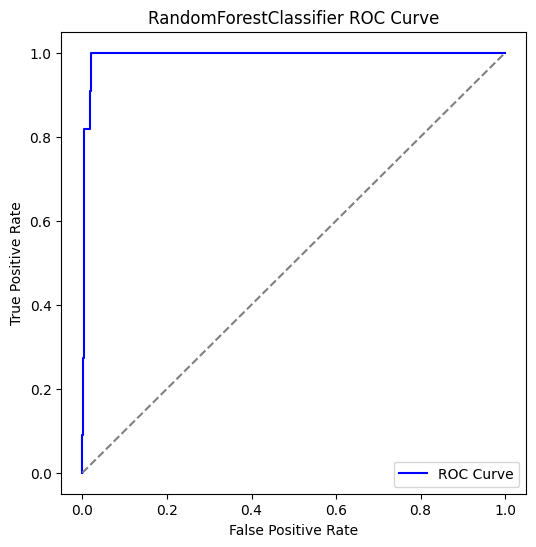


Evaluating Feedforward Neural Network:
Train Accuracy: 0.9994
Test Accuracy: 0.9867
Train Precision: 0.9989
Test Precision: 0.4667
Train Recall: 1.0000
Test Recall: 0.6364
Train F1-Score: 0.9994
Test F1-Score: 0.5385
Train ROC-AUC: 0.9994
Test ROC-AUC: 0.8137


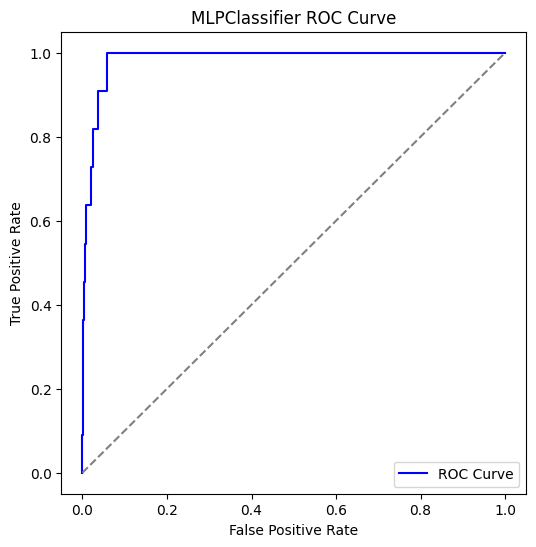

In [ ]:
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score

def handle_outliers(df, columns):
    """
    Handle outliers using the IQR method
    """
    for column in columns:
        if column in df.columns:
            Q1 = df[column].quantile(0.25)
            Q3 = df[column].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR

            # Print outlier information
            outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)][column]
            print(f"\nOutliers in {column}:")
            print(f"Number of outliers: {len(outliers)}")
            print(f"Lower bound: {lower_bound:.2f}")
            print(f"Upper bound: {upper_bound:.2f}")

            # Replace outliers with bounds
            df[column] = df[column].clip(lower=lower_bound, upper=upper_bound)

    return df

def load_and_clean_data(file_path):
    # Read the Excel file
    df = pd.read_excel(file_path)

    # Columns to drop
    columns_to_drop = [
        'WHOWID', 'ORIG_ID', 'PARTICIPANT_ID', 'LABOUR_HTN', 'LABOUR_24',
        'BIRTH_OUTCOME', 'BABY_SEX', 'BIRTH_WEIGHT','BIRTH_WEIGHT1', 'BABY_ID1', 'BIRTH_OUTCOME1',
        'BABY_SEX1', 'BABY_ID2', 'BIRTH_OUTCOME2', 'BABY_SEX2', 'BIRTH_WEIGHT2',
        'BABY_ID3', 'BIRTH_OUTCOME3', 'BABY_SEX3', 'BIRTH_WEIGHT3', 'DEL_DATE',
        'age_death_b1', 'age_death_b2', 'age_death_b3'
    ]

    # Drop the specified columns
    df = df.drop(columns=[col for col in columns_to_drop if col in df.columns], errors='ignore')

    # Convert WEALTH_INDEX
    if 'WEALTH_INDEX' in df.columns:
        wealth_mapping = {
            'Poorest': 0,
            'Poor': 1,
            'Middle': 2,
            'Rich': 3,
            'Richest': 4,
            "Don't know": -1
        }
        df['WEALTH_INDEX'] = df['WEALTH_INDEX'].map(wealth_mapping)

    # Convert TYPEDELIV to numerical values
    if 'TYPEDELIV' in df.columns:
        type_deliv_mapping = {
            'Normally through the vagina': 1,
            'Caesarean Section': 2,
            'Assisted delivery eg Forceps or vacuum': 3
        }
        df['TYPEDELIV'] = df['TYPEDELIV'].map(type_deliv_mapping).fillna(0)  # Fill missing values with 0

    # Define categorical and continuous columns
    categorical_columns = [
        'PW_EDUCATION', 'PREV_SB', 'PREV_MIS', 'PREV_PTB', 'PREV_MULTIP',
        'PREV_CS', 'SINGLE_TWIN', 'WEALTH_INDEX', 'UDIP_PROT1', 'UDIP_PROT2',
        'UDIP_PROT3', 'UDIP_PROT4', 'APH', 'TYPEDELIV'  # Added 'TYPEDELIV' here
    ]

    continuous_columns = [
        'PW_AGE', 'GRAVIDITY', 'PARITY', 'MAT_WEIGHT',
        'SBP1', 'DBP1', 'SBP2', 'DBP2', 'SBP3', 'DBP3', 'SBP4', 'DBP4',
        'GAGEBRTH'
    ]

    # Replace -88 and -77 with NaN for proper handling
    df = df.replace([-88, -77], np.nan)

    # Fill missing values in categorical columns with mode
    for col in categorical_columns:
        if col in df.columns:
            df[col] = df[col].fillna(df[col].mode()[0])

    # Fill missing values in continuous columns with mean
    for col in continuous_columns:
        if col in df.columns:
            df[col] = df[col].fillna(df[col].mean())

    # Handle outliers in continuous columns (except GAGEBRTH as it will be converted to binary)
    continuous_columns_except_target = [col for col in continuous_columns if col != 'GAGEBRTH']
    df = handle_outliers(df, continuous_columns_except_target)

    # Convert GAGEBRTH values to binary (1 if ≤154, 0 if >154)
    if 'GAGEBRTH' in df.columns:
        print("\nGAGEBRTH distribution before conversion:")
        print(f"Values <= 154: {len(df[df['GAGEBRTH'] <= 154])}")
        print(f"Values > 154: {len(df[df['GAGEBRTH'] > 154])}")

        df['GAGEBRTH'] = np.where(df['GAGEBRTH'] <= 154, 1, 0)

        print("\nGAGEBRTH distribution after conversion:")
        print(df['GAGEBRTH'].value_counts().sort_index())

    return df


def prepare_data_for_modeling(df):
    """
    Prepare data for modeling by applying SMOTE and splitting into train/test sets
    """
    # Separate features and target
    X = df.drop('GAGEBRTH', axis=1)
    y = df['GAGEBRTH']

    # Fill any remaining NaN values in the dataset with column-wise mean for continuous columns
    X = X.fillna(X.mean())  # Use mean for continuous features, can also use median, or mode for categorical

    # Split the data into train and test sets first
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # Apply SMOTE only to the training data
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_resampled)
    X_test_scaled = scaler.transform(X_test)

    return X_train_scaled, X_test_scaled, y_train_resampled, y_test, scaler

def evaluate_model_with_threshold(model, X_train, y_train, X_test, y_test, threshold=0.5):
    """
    Evaluate the model using accuracy, precision, recall, F1-score, and ROC-AUC with threshold adjustment
    """
    model.fit(X_train, y_train)
    y_train_prob = model.predict_proba(X_train)[:, 1]
    y_test_prob = model.predict_proba(X_test)[:, 1]

    # Apply custom threshold
    y_train_pred = (y_train_prob >= threshold).astype(int)
    y_test_pred = (y_test_prob >= threshold).astype(int)

    print(f"Train Accuracy: {accuracy_score(y_train, y_train_pred):.4f}")
    print(f"Test Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
    print(f"Train Precision: {precision_score(y_train, y_train_pred):.4f}")
    print(f"Test Precision: {precision_score(y_test, y_test_pred):.4f}")
    print(f"Train Recall: {recall_score(y_train, y_train_pred):.4f}")
    print(f"Test Recall: {recall_score(y_test, y_test_pred):.4f}")
    print(f"Train F1-Score: {f1_score(y_train, y_train_pred):.4f}")
    print(f"Test F1-Score: {f1_score(y_test, y_test_pred):.4f}")
    print(f"Train ROC-AUC: {roc_auc_score(y_train, y_train_pred):.4f}")
    print(f"Test ROC-AUC: {roc_auc_score(y_test, y_test_pred):.4f}")

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, label="ROC Curve", color="b")
    plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{model.__class__.__name__} ROC Curve")
    plt.legend()
    plt.show()

def main():
    try:
        # Load and clean the data
        file_path = "4501_AMANHI_With_USG.xlsx"
        df_cleaned = load_and_clean_data(file_path)

        # Prepare data for modeling
        X_train, X_test, y_train, y_test, scaler = prepare_data_for_modeling(df_cleaned)

        # Hyperparameter tuning using GridSearchCV for Random Forest
        param_grid_rf = {
            'n_estimators': [100, 200],
            'max_depth': [5, 10, 15],
            'min_samples_split': [2, 5],
            'min_samples_leaf': [1, 2]
        }
        grid_search_rf = GridSearchCV(RandomForestClassifier(), param_grid_rf, cv=5, scoring='f1')
        grid_search_rf.fit(X_train, y_train)
        print(f"Best Parameters for Random Forest: {grid_search_rf.best_params_}")
        best_rf = grid_search_rf.best_estimator_

        # Evaluate Random Forest
        print("\nEvaluating Random Forest:")
        evaluate_model_with_threshold(best_rf, X_train, y_train, X_test, y_test, threshold=0.5)

        # Neural Network model with regularization
        nn_model = MLPClassifier(max_iter=1000, alpha=0.01, random_state=42)
        print("\nEvaluating Feedforward Neural Network:")
        evaluate_model_with_threshold(nn_model, X_train, y_train, X_test, y_test, threshold=0.5)

    except FileNotFoundError:
        print(f"Error: File not found at {file_path}")
    except Exception as e:
        print(f"An error occurred: {str(e)}")

if __name__ == "__main__":
    main()
